In [ ]:
!pip install deeplake

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
import deeplake
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [95]:
ds = deeplake.load("hub://activeloop/mnist-train")

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mnist-train



|

hub://activeloop/mnist-train loaded successfully.



In [96]:
labels = np.array(ds['labels'])
images = np.array(ds['images'])

In [97]:
# Разбиение данных на тренировочный и тестовый наборы
mnist_train_X, mnist_test_X, mnist_train_y, mnist_test_y = train_test_split(images, labels, test_size=0.2, random_state=42)

In [98]:
mnist_train_X = mnist_train_X / 255
mnist_test_X = mnist_test_X / 255

In [99]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

filtered_train_images = train_images[train_labels < 5]
filtered_test_images = test_images[test_labels < 5]
filtered_train_labels = train_labels[train_labels < 5]
filtered_test_labels = test_labels[test_labels < 5]

In [100]:
fashion_train_X = filtered_train_images / 255
fashion_test_X = filtered_test_images / 255

In [101]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Задание 1
Обучиться на mnist цифрах и перенести модель, дообучить на mnist одежда (5 классов)

In [102]:
# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # MNIST - черно-белые изображения

# Энкодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
flattened = Flatten()(decoded)
out = Dense(10, activation='softmax')(flattened)

optimizer = Adam(learning_rate=0.001)
# Сборка автоэнкодера
autoencoder = Model(input_img, out)
autoencoder.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Предполагается, что mnist_train и mnist_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
mnist_train = mnist_train_X.reshape(-1, 28, 28, 1)
mnist_test = mnist_test_X.reshape(-1, 28, 28, 1)

In [103]:
mnist_train_y = tf.keras.utils.to_categorical(mnist_train_y, 10)
mnist_test_y = tf.keras.utils.to_categorical(mnist_test_y, 10)

In [104]:
autoencoder.fit(mnist_train[:1000], mnist_train_y[:1000],
                epochs=50,
                batch_size=100,
                validation_data=(mnist_test, mnist_test_y))

Epoch 1/50
10/10 [==============================] - 14s 1s/step - loss: 2.4111 - accuracy: 0.1110 - val_loss: 2.2791 - val_accuracy: 0.1093
Epoch 2/50
10/10 [==============================] - 13s 1s/step - loss: 2.2555 - accuracy: 0.1150 - val_loss: 2.1977 - val_accuracy: 0.2035
Epoch 3/50
10/10 [==============================] - 9s 1s/step - loss: 2.1503 - accuracy: 0.2550 - val_loss: 2.0609 - val_accuracy: 0.2653
Epoch 4/50
10/10 [==============================] - 10s 1s/step - loss: 1.9496 - accuracy: 0.3680 - val_loss: 1.7317 - val_accuracy: 0.4968
Epoch 5/50
10/10 [==============================] - 10s 1s/step - loss: 1.5506 - accuracy: 0.5780 - val_loss: 1.2920 - val_accuracy: 0.6786
Epoch 6/50
10/10 [==============================] - 10s 1s/step - loss: 1.1502 - accuracy: 0.7040 - val_loss: 0.9797 - val_accuracy: 0.7690
Epoch 7/50
10/10 [==============================] - 13s 1s/step - loss: 0.8908 - accuracy: 0.7770 - val_loss: 0.7367 - val_accuracy: 0.7982
Epoch 8/50
10/10 [===

In [105]:
predicted_labels = autoencoder.predict(mnist_test)

375/375 [==============================] - 9s 25ms/step


In [107]:
from sklearn.metrics import classification_report

prediction_y = np.argmax(predicted_labels, axis=-1)
mnist_test_y_1 = np.argmax(mnist_test_y, axis=-1)
# Получаем отчет о классификации
report = classification_report(mnist_test_y_1, prediction_y)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1175
           1       0.98      0.98      0.98      1322
           2       0.96      0.95      0.95      1174
           3       0.95      0.93      0.94      1219
           4       0.96      0.95      0.95      1176
           5       0.95      0.93      0.94      1104
           6       0.95      0.97      0.96      1177
           7       0.93      0.97      0.95      1299
           8       0.92      0.93      0.93      1160
           9       0.94      0.90      0.92      1194

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



In [108]:
new_autoencoder_fashion = Model(input_img, autoencoder.layers[-1].output)
for layer in new_autoencoder_fashion.layers:
    layer.trainable = False

x = Dense(128, activation='relu')(flattened)
predictions = Dense(5, activation='softmax')(x)

fashion_model_from_numbers = Model(input_img, predictions)
fashion_model_from_numbers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model_from_numbers.fit(fashion_train_X[:1000], filtered_train_labels[:1000],
                               epochs=50,
                               batch_size=100,
                               validation_data=(fashion_test_X, filtered_test_labels))

# Предсказание
predictions_from_numbers = fashion_model_from_numbers.predict(fashion_test_X)

Epoch 1/50
10/10 [==============================] - 7s 662ms/step - loss: 0.9770 - accuracy: 0.5980 - val_loss: 0.6820 - val_accuracy: 0.7360
Epoch 2/50
10/10 [==============================] - 6s 629ms/step - loss: 0.5418 - accuracy: 0.7910 - val_loss: 0.5697 - val_accuracy: 0.7836
Epoch 3/50
10/10 [==============================] - 3s 357ms/step - loss: 0.4694 - accuracy: 0.8230 - val_loss: 0.5383 - val_accuracy: 0.7990
Epoch 4/50
10/10 [==============================] - 3s 358ms/step - loss: 0.4170 - accuracy: 0.8480 - val_loss: 0.5167 - val_accuracy: 0.8082
Epoch 5/50
10/10 [==============================] - 4s 389ms/step - loss: 0.3912 - accuracy: 0.8430 - val_loss: 0.5302 - val_accuracy: 0.7968
Epoch 6/50
10/10 [==============================] - 6s 676ms/step - loss: 0.3687 - accuracy: 0.8530 - val_loss: 0.5366 - val_accuracy: 0.7960
Epoch 7/50
10/10 [==============================] - 6s 632ms/step - loss: 0.3606 - accuracy: 0.8550 - val_loss: 0.5132 - val_accuracy: 0.8040
Epoch 

In [109]:
prediction_fashion_y = np.argmax(predictions_from_numbers, axis=-1)
# Получаем отчет о классификации
report = classification_report(filtered_test_labels, prediction_fashion_y)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1000
           1       0.94      0.94      0.94      1000
           2       0.77      0.72      0.74      1000
           3       0.83      0.84      0.84      1000
           4       0.73      0.80      0.76      1000

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.84      5000
weighted avg       0.84      0.83      0.84      5000



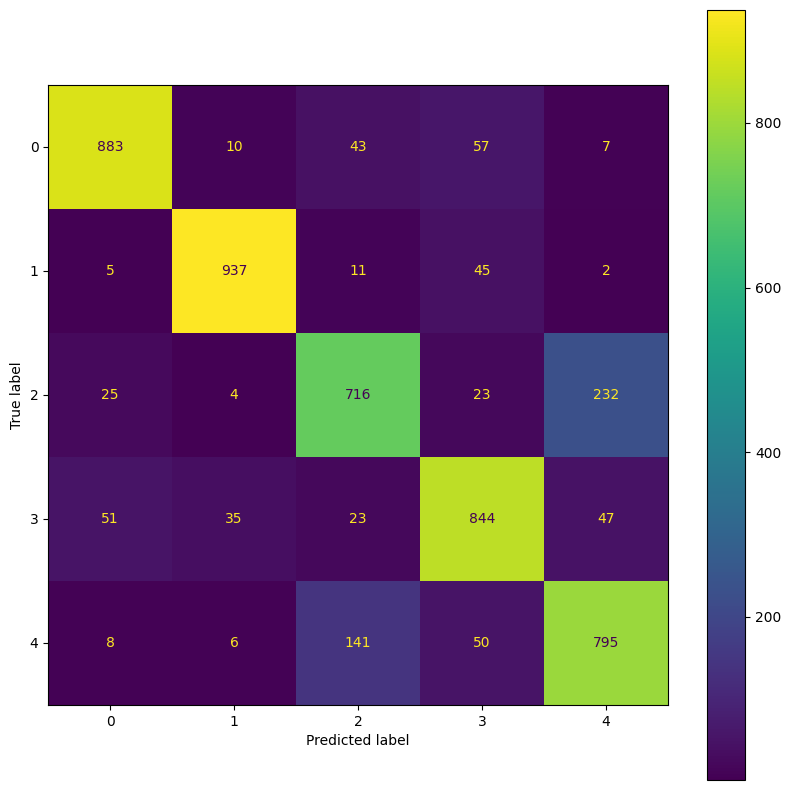

In [110]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Вычисляем confusion matrix
cm = confusion_matrix(filtered_test_labels, prediction_fashion_y)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot(ax=ax)
plt.show()

# Задание 2
Обучиться на мнист цифры с self target и перенести на одежду (5 классов)



In [79]:
# ЗАДАНИЕ 2

# Архитектура сверточного автоэнкодера
input_img = Input(shape=(28, 28, 1))  # MNIST - черно-белые изображения

# Энкодер
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Декодер
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

optimizer = Adam(learning_rate=0.01)
# Сборка автоэнкодера
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

# Предполагается, что mnist_train и mnist_test имеют размерность (num_samples, 28, 28)
# Мы просто изменяем размерность данных для соответствия форме (num_samples, 28, 28, 1)
mnist_train = mnist_train_X.reshape(-1, 28, 28, 1)
mnist_test = mnist_test_X.reshape(-1, 28, 28, 1)

In [86]:
# Обучение автоэнкодера
autoencoder.fit(mnist_train[:1000], mnist_train[:1000],
                epochs=100,
                batch_size=256,
                validation_data=(mnist_test, mnist_test))

Epoch 1/100
4/4 [==============================] - 14s 4s/step - loss: 0.0856 - val_loss: 0.0848
Epoch 2/100
4/4 [==============================] - 13s 4s/step - loss: 0.0852 - val_loss: 0.0845
Epoch 3/100
4/4 [==============================] - 13s 4s/step - loss: 0.0849 - val_loss: 0.0842
Epoch 4/100
4/4 [==============================] - 13s 4s/step - loss: 0.0846 - val_loss: 0.0839
Epoch 5/100
4/4 [==============================] - 13s 4s/step - loss: 0.0843 - val_loss: 0.0838
Epoch 6/100
4/4 [==============================] - 13s 4s/step - loss: 0.0870 - val_loss: 0.1042
Epoch 7/100
4/4 [==============================] - 9s 3s/step - loss: 0.1065 - val_loss: 0.0903
Epoch 8/100
4/4 [==============================] - 10s 3s/step - loss: 0.0962 - val_loss: 0.0900
Epoch 9/100
4/4 [==============================] - 10s 3s/step - loss: 0.0926 - val_loss: 0.0965
Epoch 10/100
4/4 [==============================] - 13s 4s/step - loss: 0.0917 - val_loss: 0.0864
Epoch 11/100
4/4 [============

375/375 [==============================] - 9s 24ms/step


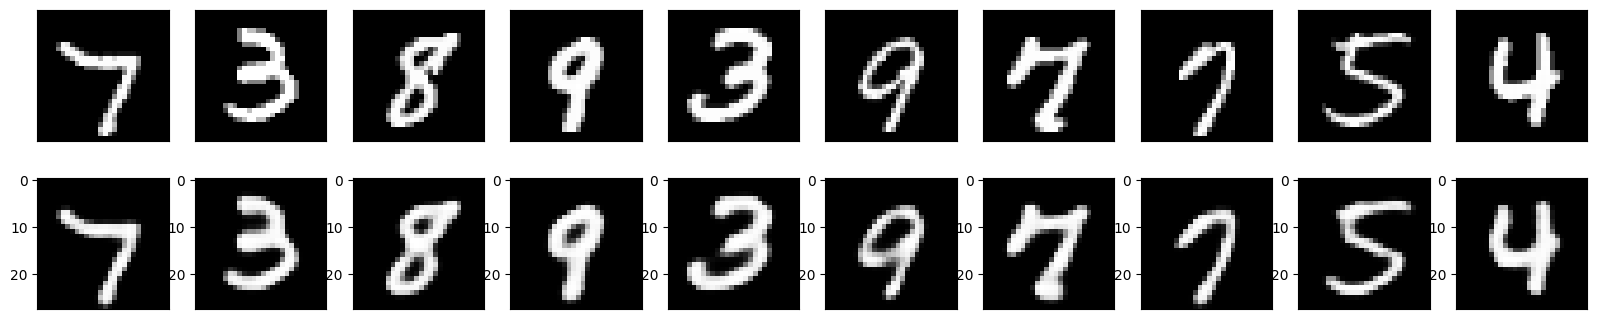

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(mnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)

In [88]:
new_autoencoder = Model(input_img, decoded)
for layer in new_autoencoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(5, activation='softmax')(x)

fashion_model = Model(input_img, predictions)
fashion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fashion_model.fit(fashion_train_X[:1000], filtered_train_labels[:1000],
                  epochs=50,
                  batch_size=256,
                  validation_data=(fashion_test_X, filtered_test_labels))

# Предсказание
predictions = fashion_model.predict(fashion_test_X)

Epoch 1/50
4/4 [==============================] - 3s 570ms/step - loss: 1.4487 - accuracy: 0.3900 - val_loss: 1.1662 - val_accuracy: 0.6486
Epoch 2/50
4/4 [==============================] - 2s 479ms/step - loss: 1.0621 - accuracy: 0.6530 - val_loss: 0.9411 - val_accuracy: 0.6660
Epoch 3/50
4/4 [==============================] - 2s 500ms/step - loss: 0.8644 - accuracy: 0.6860 - val_loss: 0.8062 - val_accuracy: 0.7368
Epoch 4/50
4/4 [==============================] - 2s 499ms/step - loss: 0.7518 - accuracy: 0.7710 - val_loss: 0.7295 - val_accuracy: 0.7540
Epoch 5/50
4/4 [==============================] - 2s 503ms/step - loss: 0.6758 - accuracy: 0.7950 - val_loss: 0.6780 - val_accuracy: 0.7574
Epoch 6/50
4/4 [==============================] - 3s 981ms/step - loss: 0.6194 - accuracy: 0.8080 - val_loss: 0.6390 - val_accuracy: 0.7706
Epoch 7/50
4/4 [==============================] - 2s 485ms/step - loss: 0.5791 - accuracy: 0.8120 - val_loss: 0.6028 - val_accuracy: 0.7872
Epoch 8/50
4/4 [====

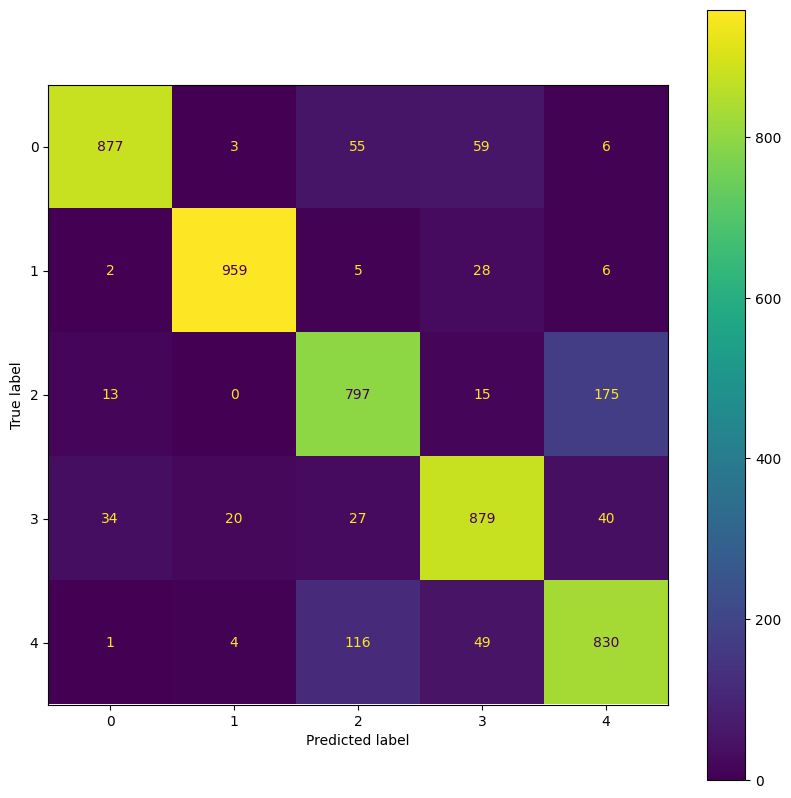

In [89]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(filtered_test_labels, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot(ax=ax)
plt.show()

In [90]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(filtered_test_labels, predicted_labels, average='macro')

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.87
Recall: 0.87
F1-score: 0.87


In [91]:
# Получаем отчет о классификации
report = classification_report(filtered_test_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1000
           1       0.97      0.96      0.97      1000
           2       0.80      0.80      0.80      1000
           3       0.85      0.88      0.87      1000
           4       0.79      0.83      0.81      1000

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



# Задание 3
Попробовать сделать полносвязную сеть для классификации mnist цифры

In [136]:
# Загрузка и предобработка данных
(mnist_train_X, mnist_train_y), (mnist_test_X, mnist_test_y) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
mnist_train = mnist_train_X.astype('float32') / 255.
mnist_test = mnist_test_X.astype('float32') / 255.

mnist_train = mnist_train.reshape(-1, 28, 28, 1)
mnist_test = mnist_test.reshape(-1, 28, 28, 1)

# Архитектура автоэнкодера
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
encoded = Dense(128, activation='relu')(x)

x = Dense(256, activation='relu')(encoded)
x = Dense(512, activation='relu')(x)
x = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.001)
# Обучение автоэнкодера на MNIST
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
autoencoder.fit(mnist_train, mnist_train,
                epochs=50,
                batch_size=512,
                validation_data=(mnist_test, mnist_test))

Epoch 1/50
118/118 [==============================] - 21s 139ms/step - loss: 0.0657 - accuracy: 0.7873 - val_loss: 0.0373 - val_accuracy: 0.8056
Epoch 2/50
118/118 [==============================] - 8s 71ms/step - loss: 0.0297 - accuracy: 0.8091 - val_loss: 0.0230 - val_accuracy: 0.8102
Epoch 3/50
118/118 [==============================] - 11s 91ms/step - loss: 0.0209 - accuracy: 0.8124 - val_loss: 0.0184 - val_accuracy: 0.8121
Epoch 4/50
118/118 [==============================] - 12s 97ms/step - loss: 0.0178 - accuracy: 0.8133 - val_loss: 0.0163 - val_accuracy: 0.8129
Epoch 5/50
118/118 [==============================] - 10s 84ms/step - loss: 0.0158 - accuracy: 0.8139 - val_loss: 0.0147 - val_accuracy: 0.8132
Epoch 6/50
118/118 [==============================] - 12s 104ms/step - loss: 0.0141 - accuracy: 0.8141 - val_loss: 0.0130 - val_accuracy: 0.8133
Epoch 7/50
118/118 [==============================] - 9s 76ms/step - loss: 0.0131 - accuracy: 0.8144 - val_loss: 0.0124 - val_accuracy:

313/313 [==============================] - 2s 5ms/step


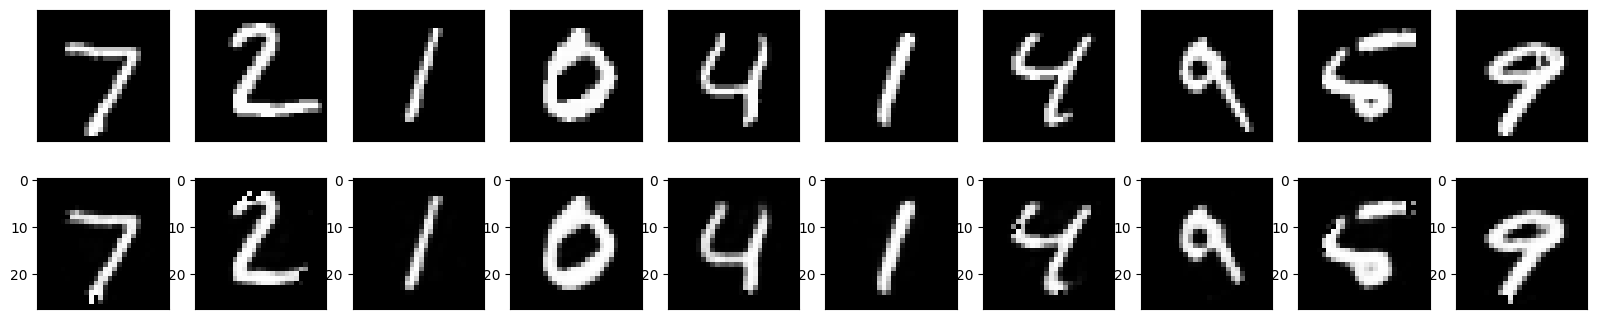

In [137]:
# Предсказание на тестовом наборе данных
decoded_imgs = autoencoder.predict(mnist_test)

n = 10  # количество изображений для отображения
plt.figure(figsize=(20, 4))

for i in range(n):
    # Отображение оригинальных изображений
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленных изображений
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)

In [145]:
new_autoencoder = Model(input_img, decoded)
for layer in new_autoencoder.layers:
    layer.trainable = False

flattened = Flatten()(encoded)
x = Dense(128, activation='relu')(flattened)
predictions = Dense(10, activation='softmax')(x)

model = Model(input_img, predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(mnist_train, mnist_train_y,
          epochs=30,
          batch_size=256,
          validation_data=(mnist_test, mnist_test_y))

# Предсказание
predictions = model.predict(mnist_test)

Epoch 1/30
235/235 [==============================] - 5s 16ms/step - loss: 1.1379 - accuracy: 0.6736 - val_loss: 0.4550 - val_accuracy: 0.8646
Epoch 2/30
235/235 [==============================] - 3s 12ms/step - loss: 0.4000 - accuracy: 0.8808 - val_loss: 0.3419 - val_accuracy: 0.8967
Epoch 3/30
235/235 [==============================] - 2s 11ms/step - loss: 0.3338 - accuracy: 0.9013 - val_loss: 0.2950 - val_accuracy: 0.9145
Epoch 4/30
235/235 [==============================] - 3s 12ms/step - loss: 0.2983 - accuracy: 0.9118 - val_loss: 0.2698 - val_accuracy: 0.9223
Epoch 5/30
235/235 [==============================] - 4s 16ms/step - loss: 0.2722 - accuracy: 0.9201 - val_loss: 0.2539 - val_accuracy: 0.9253
Epoch 6/30
235/235 [==============================] - 3s 11ms/step - loss: 0.2485 - accuracy: 0.9275 - val_loss: 0.2304 - val_accuracy: 0.9329
Epoch 7/30
235/235 [==============================] - 2s 11ms/step - loss: 0.2312 - accuracy: 0.9311 - val_loss: 0.2106 - val_accuracy: 0.9366

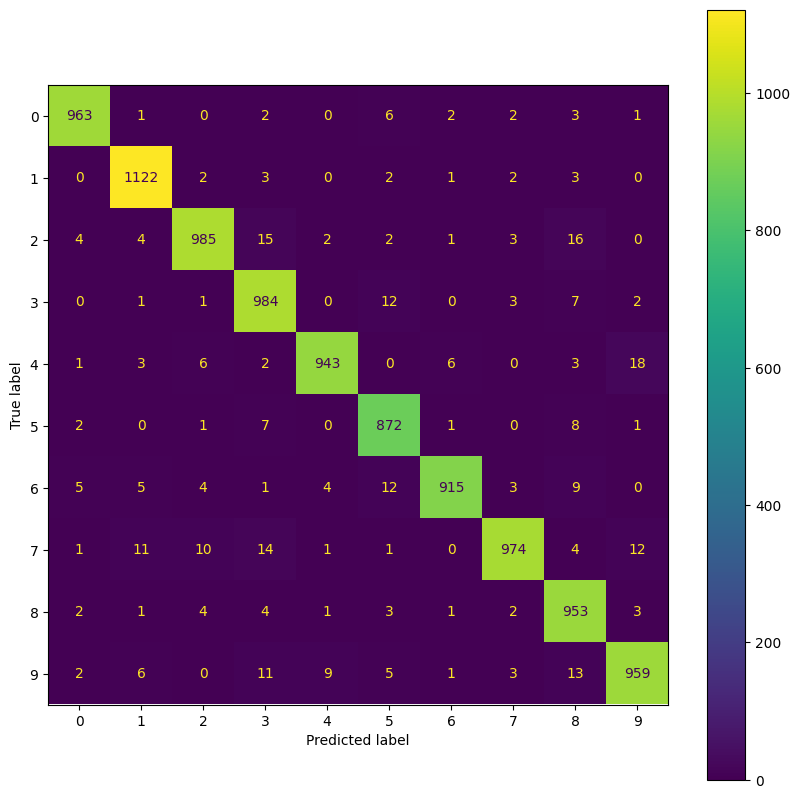

In [146]:
# Получаем предсказанные метки классов из вероятностных предсказаний
predicted_labels = np.argmax(predictions, axis=-1)

# Вычисляем confusion matrix
cm = confusion_matrix(mnist_test_y, predicted_labels)

# Визуализируем confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(ax=ax)
plt.show()

In [147]:
# Получаем отчет о классификации
report = classification_report(mnist_test_y, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.94      0.97      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.98      0.97       892
           6       0.99      0.96      0.97       958
           7       0.98      0.95      0.96      1028
           8       0.94      0.98      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

